In [416]:
# Chargement des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import os

# Algorithmes simples
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *

# Algorithmes ensemblistes
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

# Utiles
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from sklearn import set_config
from statistics import stdev

# Normalisation
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer

# Scoring
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore')


In [417]:
print(os.getcwd())

/Users/innakonar/Desktop


In [418]:
data = pd.read_csv("../building_energy_cleaned.csv")

In [419]:
df=data.copy()

In [420]:
df.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,DistanceToSeattle,GasScore,ElectricityScore,SteamUse(kBtu)Score,ParkingScore,BuildingScore,SurfacePerBuilding,SurfacePerFloor,TotalUseTypeNumber
0,Hotel,DOWNTOWN,1.0,12,88434,Hotel,60.0,7226362.5,249.98,96,0.497538,0.176638,0.546060,0.277302,0.000000,1.000000,88434.0,7369.500000,1
1,Hotel,DOWNTOWN,1.0,11,103566,Hotel,61.0,8387933.0,295.86,27,0.489059,0.613391,0.386609,0.000000,0.145453,0.854547,88502.0,8045.636364,3
2,Hotel,DOWNTOWN,1.0,41,956110,Hotel,43.0,72587024.0,2089.28,54,0.603129,0.020579,0.682307,0.297113,0.205748,0.794252,759392.0,18521.756098,1
3,Hotel,DOWNTOWN,1.0,10,61320,Hotel,56.0,6794584.0,286.43,97,0.586830,0.266567,0.407519,0.325913,0.000000,1.000000,61320.0,6132.000000,1
4,Hotel,DOWNTOWN,1.0,18,175580,Hotel,75.0,14172606.0,505.01,43,0.651898,0.621198,0.378802,0.000000,0.353115,0.646885,113580.0,6310.000000,3


In [421]:
dim=df.shape
print(f"Rows:{dim[0]} Columns:{dim[1]}")

Rows:987 Columns:19


In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PrimaryPropertyType     987 non-null    object 
 1   Neighborhood            987 non-null    object 
 2   NumberofBuildings       987 non-null    float64
 3   NumberofFloors          987 non-null    int64  
 4   PropertyGFATotal        987 non-null    int64  
 5   LargestPropertyUseType  987 non-null    object 
 6   ENERGYSTARScore         987 non-null    float64
 7   SiteEnergyUse(kBtu)     987 non-null    float64
 8   TotalGHGEmissions       987 non-null    float64
 9   BuildingAge             987 non-null    int64  
 10  DistanceToSeattle       987 non-null    float64
 11  GasScore                987 non-null    float64
 12  ElectricityScore        987 non-null    float64
 13  SteamUse(kBtu)Score     987 non-null    float64
 14  ParkingScore            987 non-null    fl

In [423]:
ENERGYSTARS_core=df['ENERGYSTARScore']
df=df.drop('ENERGYSTARScore', axis=1)


In [424]:
df.rename(columns={'SiteEnergyUse(kBtu)': 'SiteEnergyUse'}, inplace=True)

In [425]:
selected_columns = ['Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'DistanceToSeattle', 'ParkingScore', 'BuildingScore', 'SurfacePerBuilding',
                    'SurfacePerFloor', 'TotalUseTypeNumber','GasScore','ElectricityScore','SteamUse(kBtu)Score','PrimaryPropertyType','LargestPropertyUseType']
X = df[selected_columns]
y_site = df["SiteEnergyUse"]


# Split the dataset into training and test sets for each target variable
X_train_site, X_test_site, y_train_site, y_test_site = train_test_split(X, y_site, test_size=0.2, random_state=42)
print(f"La taille de données d'entrainement : {X_train_site.shape[0]}")
print(f"La taille de données d'entrainement : {X_test_site.shape[0]}")

La taille de données d'entrainement : 789
La taille de données d'entrainement : 198


In [426]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'DistanceToSeattle', 'ParkingScore',
                                      'BuildingScore', 'SurfacePerBuilding', 'SurfacePerFloor', 'TotalUseTypeNumber','GasScore','ElectricityScore','SteamUse(kBtu)Score']),
        ('cat', categorical_transformer, ['Neighborhood','PrimaryPropertyType','LargestPropertyUseType'])
    ])

X_train_site_encoded = preprocessor.fit_transform(X_train_site)
X_test_site_encoded = preprocessor.transform(X_test_site)

In [427]:
# Log transform the target variables
y_train_site_log = np.log1p(y_train_site)

In [428]:
def score (modele, R2, RMSE, MAE, time):
    df_scores.loc[df_scores.shape[0]] = [modele, R2, RMSE, MAE, time]
    df_scores.sort_values(by='R2', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    return df_scores

In [429]:
scores = []
df_scores = pd.DataFrame(
    scores, columns=['modele', 'R2', 'RMSE', 'MAE', 'time'])

In [430]:
def plot_pred(true_values, predicted_values, color, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predicted_values, color=color, alpha=0.6)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='black', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()

In [431]:
#LinearRegression()
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pipeline = Pipeline([
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__normalize': [True, False]
    
}

# GridSearchCV - TotalGHGEmissions
grid_cv_site = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', refit='neg_mean_absolute_error')
grid_cv_site.fit(X_train_site_encoded, y_train_site_log)

best_params_site = grid_cv_site.best_params_
best_score_site = grid_cv_site.best_score_


print("Best Parameters for TotalGHGEmissions:", best_params_site)
print("Best Score for TotalGHGEmissions:", best_score_site)


Best Parameters for TotalGHGEmissions: {'regressor__fit_intercept': True, 'regressor__normalize': False}
Best Score for TotalGHGEmissions: -0.5494517960235987


In [432]:
best_model_site = grid_cv_site.best_estimator_
y_pred_site = best_model_site.predict(X_test_site_encoded)


In [433]:
# Affichage des scores
rmse_LR = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_site))), 3)
mae_LR = round(mean_absolute_error(y_test_site, np.expm1(y_pred_site)), 3)
time_LR = round(grid_cv_site.cv_results_['mean_fit_time'].max(), 3)
r2_LR = r2_score(y_test_site, np.expm1(y_pred_site))
# Les meilleur parametres
print("Best Parameters for TotalGHGEmissions:")
print(grid_cv_site.best_params_)
# Ajoute à la liste des scores
score('Linear Regression', r2_LR, rmse_LR, mae_LR,  time_LR)

Best Parameters for TotalGHGEmissions:
{'regressor__fit_intercept': True, 'regressor__normalize': False}


,modele,R2,RMSE,MAE,time
0,Linear Regression,-3.592405,68991695.69,1.129509e+07,0.015


In [434]:
#MLPRegressor
pipeline_mlp_site = Pipeline([
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 100, 100),max_iter=1000, solver='sgd', random_state=5))
])

param_grid_mlp_site = {
    'regressor__max_iter': [100, 500, 1000],
    'regressor__learning_rate_init': [0.001, 0.01]
}

grid_cv_mlp_site = GridSearchCV(pipeline_mlp_site, param_grid_mlp_site, cv=5, scoring='neg_mean_absolute_error', refit='neg_mean_absolute_error')
grid_cv_mlp_site.fit(X_train_site_encoded, y_train_site_log)

best_params_mlp_site = grid_cv_mlp_site.best_params_
best_score_mlp_site = grid_cv_mlp_site.best_score_
best_estimator_mlp_site = grid_cv_mlp_site.best_estimator_

print("Best Parameters for MLPRegressor - GHG Emissions:")
print(best_params_mlp_site)
print("Best Score for MLPRegressor - GHG Emissions:")
print(best_score_mlp_site)
print("Best Estimator for MLPRegressor - GHG Emissions:")
print(best_estimator_mlp_site)

Best Parameters for MLPRegressor - GHG Emissions:
{'regressor__learning_rate_init': 0.01, 'regressor__max_iter': 100}
Best Score for MLPRegressor - GHG Emissions:
-0.4736869088107519
Best Estimator for MLPRegressor - GHG Emissions:
Pipeline(steps=[('regressor',
                 MLPRegressor(hidden_layer_sizes=(100, 100, 100),
                              learning_rate_init=0.01, max_iter=100,
                              random_state=5, solver='sgd'))])


In [435]:
y_pred_MLP = grid_cv_mlp_site.best_estimator_.predict(X_test_site_encoded)


In [436]:
# Calculate MAE for GHG Emissions
mae_site = mean_absolute_error(y_test_site, np.expm1(y_pred_MLP))

# Calculate R^2 for GHG Emissions
r2_site = r2_score(y_test_site, np.expm1(y_pred_MLP))


print("GHG Emissions:")
print("MAE:", mae_site)
print("R^2:", r2_site)


GHG Emissions:
MAE: 5684656.368072647
R^2: 0.4960953726905436


In [437]:
# Affichage des scores
r2_MLP = r2_score(y_test_site, np.expm1(y_pred_MLP))
rmse_MLP = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_MLP))), 3)
mae_MLP = round(mean_absolute_error(y_test_site, np.expm1(y_pred_MLP)), 3)
time_MLP = round(grid_cv_site.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(best_params_mlp_site)

# Ajoute à la liste des scores
score('MLPRegressor', r2_MLP, rmse_MLP, mae_MLP,  time_MLP)

{'regressor__learning_rate_init': 0.01, 'regressor__max_iter': 100}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,22853405.32,5.684656e+06,0.015
1,Linear Regression,-3.592405,68991695.69,1.129509e+07,0.015


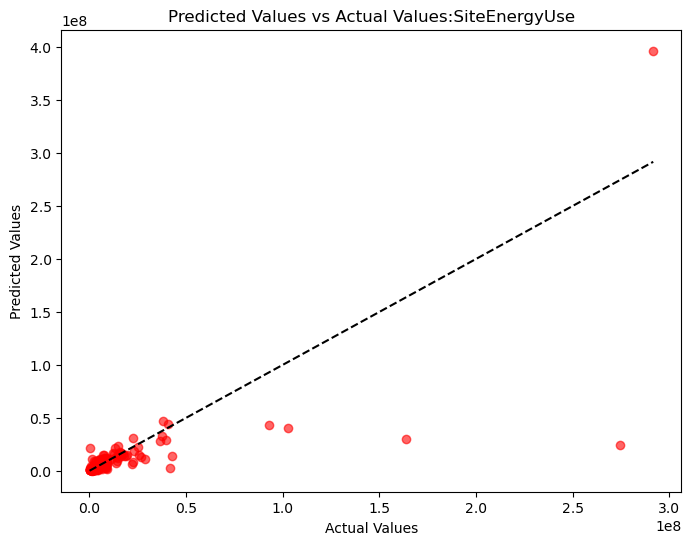

In [438]:
plot_pred(y_test_site, np.expm1(y_pred_MLP), color="red", title="Predicted Values vs Actual Values:SiteEnergyUse")

In [439]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_cv_mlp_site, X_train_site_encoded.toarray(), y_train_site_log, n_repeats=10, random_state=0)

importance = result.importances_mean

sorted_indices = np.argsort(importance)[::-1]

for i, idx in enumerate(sorted_indices):
    print(f"Feature {i+1}: Index {idx} - Importance: {importance[idx]}")


Feature 1: Index 11 - Importance: 0.23072147785779804
Feature 2: Index 2 - Importance: 0.22454829825374886
Feature 3: Index 7 - Importance: 0.2045394241697973
Feature 4: Index 1 - Importance: 0.17867598917876742
Feature 5: Index 10 - Importance: 0.14287865710557585
Feature 6: Index 8 - Importance: 0.11112646214939086
Feature 7: Index 5 - Importance: 0.0932265556279851
Feature 8: Index 9 - Importance: 0.0773440442085821
Feature 9: Index 3 - Importance: 0.06879940689462052
Feature 10: Index 6 - Importance: 0.06240106611475458
Feature 11: Index 4 - Importance: 0.06001247359119488
Feature 12: Index 40 - Importance: 0.04954066289644883
Feature 13: Index 52 - Importance: 0.045199711374649336
Feature 14: Index 12 - Importance: 0.03214649994781429
Feature 15: Index 16 - Importance: 0.027986646071932353
Feature 16: Index 38 - Importance: 0.024880423535160495
Feature 17: Index 30 - Importance: 0.024775825173699632
Feature 18: Index 48 - Importance: 0.024130293621247863
Feature 19: Index 0 - Impo

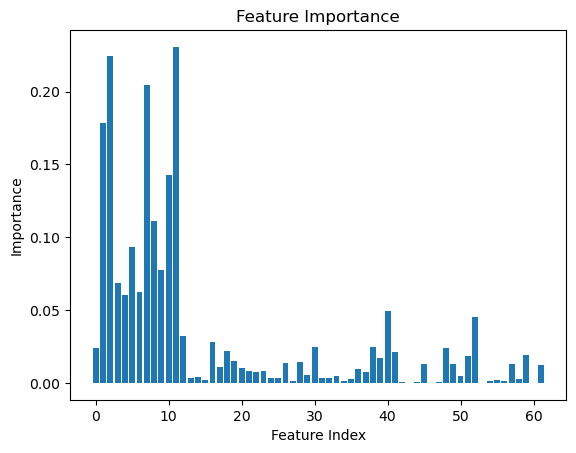

In [440]:
plt.bar(range(len(importance)), importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()



In [441]:
parametres_Lasso = {}


grid_Lasso = GridSearchCV(Lasso(), parametres_Lasso, cv=5)
modele_Lasso = grid_Lasso.fit(X_train_site_encoded, y_train_site_log)
y_pred_Lasso = grid_Lasso.predict(X_test_site_encoded)


r2_Lasso = r2_score(y_test_site, np.expm1(y_pred_Lasso))
rmse_Lasso = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_Lasso))), 3)
mae_Lasso = round(mean_absolute_error(y_test_site, np.expm1(y_pred_Lasso)), 3)
time_Lasso = round(grid_Lasso.cv_results_['mean_fit_time'].max(), 3)


print(grid_Lasso.best_params_)


score('Lasso', r2_Lasso, rmse_Lasso, mae_Lasso, time_Lasso)


{}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
2,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [442]:
parametres_Ridge = {}
grid_Ridge = GridSearchCV(Ridge(), parametres_Ridge, cv=5)
grid_Ridge.fit(X_train_site_encoded, y_train_site_log)
y_pred_Ridge = grid_Ridge.predict(X_test_site_encoded)


r2_Ridge = round(r2_score(y_test_site, np.expm1(y_pred_Ridge)), 3)
rmse_Ridge = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_Ridge))), 3)
mae_Ridge = round(mean_absolute_error(y_test_site, np.expm1(y_pred_Ridge)), 3)
time_Ridge = round(grid_Ridge.cv_results_['mean_fit_time'].max(), 3)

print("Best Parameters for Ridge - SiteEnergyUse:")
print(grid_Ridge.best_params_)
                  

score('Ridge', r2_Ridge, rmse_Ridge, mae_Ridge, time_Ridge)


Best Parameters for Ridge - SiteEnergyUse:
{}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
2,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
3,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [443]:
# ElasticNet - SiteEnergyUse
pipeline_energy = Pipeline([
    ('regressor', TransformedTargetRegressor(regressor=ElasticNet()))
])

param_grid_energy = {
    'regressor__regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__regressor__l1_ratio': [0.2, 0.5, 0.8]
}

grid_cv_energy = GridSearchCV(pipeline_energy, param_grid_energy, cv=5, scoring='neg_mean_absolute_error', refit='neg_mean_absolute_error')
grid_cv_energy.fit(X_train_site_encoded, y_train_site_log)

# Get the best parameters and scores for SiteEnergyUse
best_params_energy = grid_cv_energy.best_params_
best_score_energy = grid_cv_energy.best_score_




In [444]:
print("GHG Emissions - Best Parameters:", grid_cv_energy.best_params_)
print("GHG Emissions - Best Score:", grid_cv_energy.best_score_)

GHG Emissions - Best Parameters: {'regressor__regressor__alpha': 0.1, 'regressor__regressor__l1_ratio': 0.2}
GHG Emissions - Best Score: -0.6242207931161221


In [445]:
y_pred_energy = grid_cv_energy.predict(X_test_site_encoded)

# Calculate RMSE and R² scores on the test set for SiteEnergyUse
mse_energy = mean_squared_error(y_test_site, np.expm1(y_pred_energy))
rmse_energy = np.sqrt(mse_energy)
r2_energy = r2_score(y_test_site, np.expm1(y_pred_energy))

# Print the results
print("SiteEnergyUse:")
print("MSE:", mse_energy)
print("RMSE:", rmse_energy)
print("R^2:", r2_energy)

SiteEnergyUse:
MSE: 4429751399727394.5
RMSE: 66556377.60370823
R^2: -3.2739147587712827


In [446]:
r2_EN = r2_score(y_test_site, np.expm1(y_pred_energy))
rmse_EN = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_energy))), 3)
mae_EN = round(mean_absolute_error(y_test_site, np.expm1(y_pred_energy)), 3)
time_EN = round(grid_cv_energy.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(best_params_energy)


score('ElasticNet', r2_EN, rmse_EN, mae_EN,  time_EN)

{'regressor__regressor__alpha': 0.1, 'regressor__regressor__l1_ratio': 0.2}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
2,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
3,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
4,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [447]:
#RandomForestRegressor

clf_site = RandomForestRegressor()
parameters = {
    'n_estimators': range(100, 200, 300),
    'max_depth': range(1, 21, 5),
    'min_samples_leaf': range(2, 5, 10),
    'min_samples_split': range(2, 10, 2)
}

scoring = ('r2', 'neg_mean_absolute_error')

grid_site = GridSearchCV(clf_site, parameters, scoring=scoring, refit='neg_mean_absolute_error', cv=5)
grid_site.fit(X_train_site_encoded, y_train_site_log)

best_params = grid_site.best_params_
print(best_params)

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


In [448]:
best_model_site = grid_site.best_estimator_  
best_model_site.fit(X_train_site_encoded, y_train_site_log)

feature_importances = best_model_site.feature_importances_

Feature: 0, Score: 0.00143
Feature: 1, Score: 0.00388
Feature: 2, Score: 0.73264
Feature: 3, Score: 0.01736
Feature: 4, Score: 0.01484
Feature: 5, Score: 0.00174
Feature: 6, Score: 0.00152
Feature: 7, Score: 0.02478
Feature: 8, Score: 0.01989
Feature: 9, Score: 0.00513
Feature: 10, Score: 0.01248
Feature: 11, Score: 0.03450
Feature: 12, Score: 0.00103
Feature: 13, Score: 0.00070
Feature: 14, Score: 0.00031
Feature: 15, Score: 0.00100
Feature: 16, Score: 0.00031
Feature: 17, Score: 0.00055
Feature: 18, Score: 0.00259
Feature: 19, Score: 0.00036
Feature: 20, Score: 0.00066
Feature: 21, Score: 0.00021
Feature: 22, Score: 0.00182
Feature: 23, Score: 0.00081
Feature: 24, Score: 0.00054
Feature: 25, Score: 0.00008
Feature: 26, Score: 0.00215
Feature: 27, Score: 0.00403
Feature: 28, Score: 0.00082
Feature: 29, Score: 0.00031
Feature: 30, Score: 0.00029
Feature: 31, Score: 0.00020
Feature: 32, Score: 0.00019
Feature: 33, Score: 0.00177
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

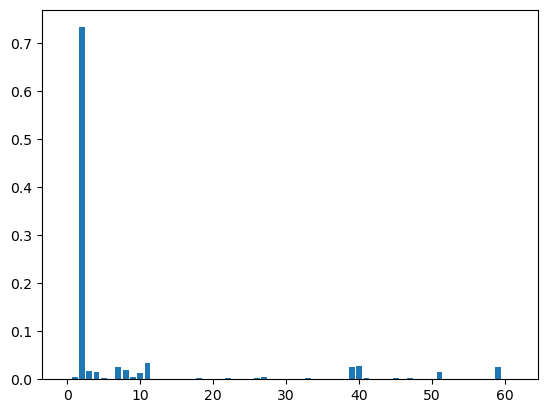

In [449]:
for i,v in enumerate(feature_importances):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(feature_importances))], feature_importances)
plt.show()

In [450]:
y_pred_RFR = best_model_site.predict(X_test_site_encoded)

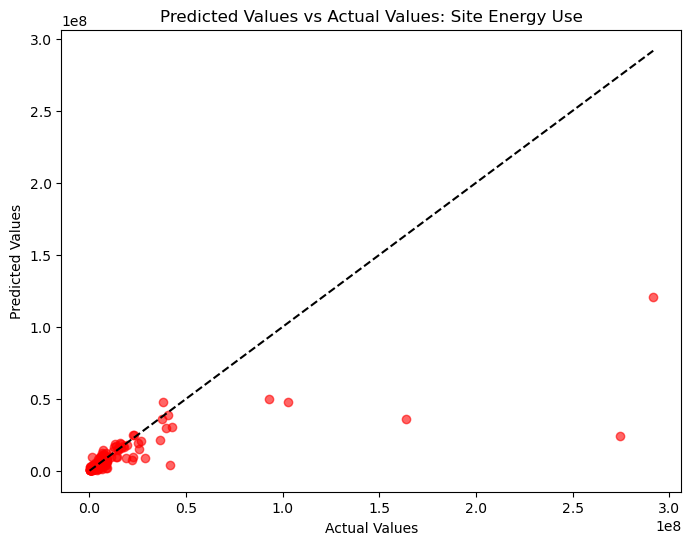

In [451]:
plot_pred(y_test_site, np.expm1(y_pred_RFR), color="red", title="Predicted Values vs Actual Values: Site Energy Use")

In [452]:
r2_RFR = r2_score(y_test_site, np.expm1(y_pred_RFR))
rmse_RFR = round(np.sqrt(mean_squared_error(y_test_site, np.expm1(y_pred_RFR))), 3)
mae_RFR = round(mean_absolute_error(y_test_site, np.expm1(y_pred_RFR)), 3)
time_RFR = round(grid_cv_site.cv_results_['mean_fit_time'].max(), 3)

# Les meilleur parametres
print(best_params_site)


score('RandomForestRegressor', r2_RFR, rmse_RFR, mae_RFR,  time_RFR)

{'regressor__fit_intercept': True, 'regressor__normalize': False}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
2,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
3,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
4,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
5,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [453]:
parameters_SVR = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

clf_energy = SVR(kernel="rbf", gamma="auto", C=100)
grid_SVR_energy = GridSearchCV(clf_energy, parameters_SVR, cv=5)
grid_SVR_energy.fit(X_train_site_encoded, y_train_site_log)
y_pred_SVR_energy = grid_SVR_energy.predict(X_test_site_encoded)

r2_SVR_energy = round(r2_score(y_test_site, np.expm1(y_pred_SVR_energy)), 3)
rmse_SVR_energy = round(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_SVR_energy)), 3)
mae_SVR_energy = round(mean_absolute_error(y_test_site, np.expm1(y_pred_SVR_energy)), 3)
time_SVR_energy = round(grid_SVR_energy.cv_results_['mean_fit_time'].max(), 3)

print(grid_SVR_energy.best_params_)

score('SVR1', r2_SVR_energy, rmse_SVR_energy, mae_SVR_energy, time_SVR_energy)


{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
2,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
3,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
4,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
5,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
6,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


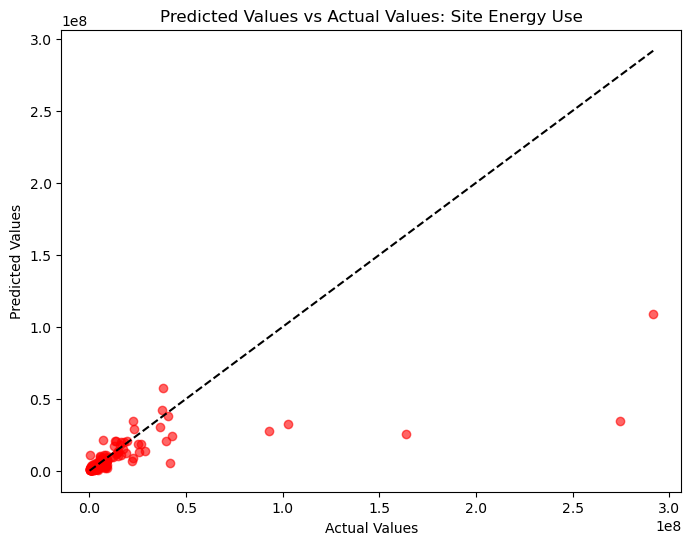

In [454]:
plot_pred(y_test_site, np.expm1(y_pred_SVR_energy), color="red", title="Predicted Values vs Actual Values: Site Energy Use")


In [455]:
parametres_kNN = {
    'n_neighbors': np.arange(1, 30),
    'metric': ['euclidean', 'manhattan', 'minkowski']
    
}

grid_KNN = GridSearchCV(KNeighborsRegressor(), parametres_kNN, cv=5)
grid_KNN.fit(X_train_site_encoded, y_train_site_log)
y_pred_KNN = grid_KNN.predict(X_test_site_encoded)

In [456]:
r2_KNN = round(r2_score(y_test_site, np.expm1(y_pred_KNN)), 3)
rmse_KNN = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_KNN))), 3)
mae_KNN = round(mean_absolute_error(y_test_site, np.expm1(y_pred_KNN)), 3)
time_KNN = round(grid_KNN.cv_results_['mean_fit_time'].max(), 3)

print(grid_KNN.best_params_)
score('K Neighbors Regressor', r2_KNN, rmse_KNN, mae_KNN, time_KNN)

{'metric': 'manhattan', 'n_neighbors': 5}


,modele,R2,RMSE,MAE,time
0,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
1,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
2,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
3,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
4,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
5,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
6,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
7,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [457]:
#Gradient Boosting Regressor
parameters_XG = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

grid_XG = GridSearchCV(GradientBoostingRegressor(), parameters_XG, cv=5)
grid_XG.fit(X_train_site_encoded, y_train_site_log)
y_pred_XG = grid_XG.predict(X_test_site_encoded)

In [458]:
r2_XG = round(r2_score(y_test_site, np.expm1(y_pred_XG)), 3)
rmse_XG = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_XG))), 3)
mae_XG = round(mean_absolute_error(y_test_site, np.expm1(y_pred_XG)), 3)
time_XG = round(grid_XG.cv_results_['mean_fit_time'].max(), 3)

print(grid_XG.best_params_)
score('Gradient Boosting Regressor', r2_XG, rmse_XG, mae_XG, time_XG)

{'max_depth': 3, 'max_features': 'auto'}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
1,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
2,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
3,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
4,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
5,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
6,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
7,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
8,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


In [459]:
#Decision Tree Regressor
parameters_DT = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

grid_DT = GridSearchCV(DecisionTreeRegressor(random_state = 42), parameters_DT, cv=5)
grid_DT.fit(X_train_site_encoded, y_train_site_log)
y_pred_DT = grid_DT.predict(X_test_site_encoded)

In [460]:
r2_DT = round(r2_score(y_test_site, np.expm1(y_pred_DT)), 3)
rmse_DT = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_DT))), 3)
mae_DT = round(mean_absolute_error(y_test_site, np.expm1(y_pred_DT)), 3)
time_DT = round(grid_DT.cv_results_['mean_fit_time'].max(), 3)

print(grid_DT.best_params_)
score('Decision Tree Regressor', r2_DT, rmse_DT, mae_DT, time_DT)

{'max_depth': 5, 'max_features': 'auto'}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
1,Decision Tree Regressor,0.555000,2.148535e+07,5.171799e+06,0.008
2,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
3,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
4,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
5,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
6,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
7,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
8,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010
9,Linear Regression,-3.592405,6.899170e+07,1.129509e+07,0.015


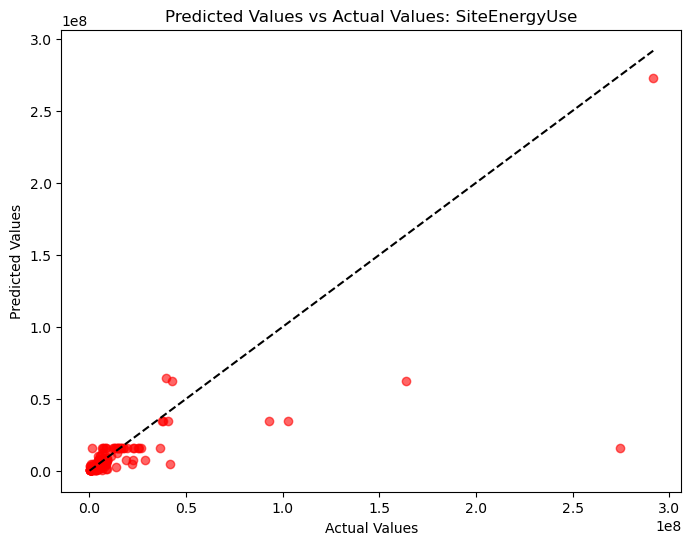

In [461]:
plot_pred(y_test_site, np.expm1(y_pred_DT), color="red", title="Predicted Values vs Actual Values: SiteEnergyUse")


In [462]:
#BaggingRegressor
parameters_BR = {
    "n_estimators": [10, 50, 100],
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0]
}

grid_BR = GridSearchCV(BaggingRegressor(random_state=42), parameters_BR, cv=5)
grid_BR.fit(X_train_site_encoded, y_train_site_log)
y_pred_BR = grid_BR.predict(X_test_site_encoded)

r2_BR = round(r2_score(y_test_site, np.expm1(y_pred_BR)), 3)
rmse_BR = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_BR))), 3)
mae_BR = round(mean_absolute_error(y_test_site, np.expm1(y_pred_BR)), 3)
time_BR = round(grid_BR.cv_results_['mean_fit_time'].max(), 3)

print(grid_BR.best_params_)
score('Bagging Regressor', r2_BR, rmse_BR, mae_BR, time_BR)

{'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
1,Decision Tree Regressor,0.555000,2.148535e+07,5.171799e+06,0.008
2,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
3,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
4,Bagging Regressor,0.424000,2.443508e+07,5.457322e+06,0.756
5,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
6,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
7,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
8,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006
9,ElasticNet,-3.273915,6.655638e+07,1.161955e+07,0.010


In [463]:
#Extra Trees Regressor
parameters_ET = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

grid_ET = GridSearchCV(ExtraTreesRegressor(random_state=42), parameters_ET, cv=5)
grid_ET.fit(X_train_site_encoded, y_train_site_log)
y_pred_ET = grid_ET.predict(X_test_site_encoded)


In [464]:
r2_ET = round(r2_score(y_test_site, np.expm1(y_pred_ET)), 3)
rmse_ET = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_ET))), 3)
mae_ET = round(mean_absolute_error(y_test_site, np.expm1(y_pred_ET)), 3)
time_ET = round(grid_ET.cv_results_['mean_fit_time'].max(), 3)

print(grid_ET.best_params_)
score('Extra Trees Regressor', r2_ET, rmse_ET, mae_ET, time_ET)


{'max_depth': 12, 'max_features': 'auto'}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
1,Decision Tree Regressor,0.555000,2.148535e+07,5.171799e+06,0.008
2,Extra Trees Regressor,0.552000,2.155473e+07,4.973834e+06,0.508
3,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
4,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
5,Bagging Regressor,0.424000,2.443508e+07,5.457322e+06,0.756
6,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
7,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
8,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002
9,Ridge,-3.186000,6.586693e+07,1.136689e+07,0.006


In [465]:
#AdaBoostRegressor

parameters_AB = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0]
}

grid_AB = GridSearchCV(AdaBoostRegressor(random_state=42), parameters_AB, cv=5)
grid_AB.fit(X_train_site_encoded, y_train_site_log)
y_pred_AB = grid_AB.predict(X_test_site_encoded)


In [466]:
r2_AB = round(r2_score(y_test_site, np.expm1(y_pred_AB)), 3)
rmse_AB = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_AB))), 3)
mae_AB = round(mean_absolute_error(y_test_site, np.expm1(y_pred_AB)), 3)
time_AB = round(grid_AB.cv_results_['mean_fit_time'].max(), 3)

print(grid_AB.best_params_)
score('AdaBoost Regressor', r2_AB, rmse_AB, mae_AB, time_AB)

{'learning_rate': 1.0, 'n_estimators': 50}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
1,Decision Tree Regressor,0.555000,2.148535e+07,5.171799e+06,0.008
2,Extra Trees Regressor,0.552000,2.155473e+07,4.973834e+06,0.508
3,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
4,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
5,Bagging Regressor,0.424000,2.443508e+07,5.457322e+06,0.756
6,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
7,AdaBoost Regressor,0.335000,2.624749e+07,6.695223e+06,0.480
8,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001
9,Lasso,-0.059046,3.313098e+07,9.443971e+06,0.002


In [467]:
#Evaluation des modèles avec Energy Star Score

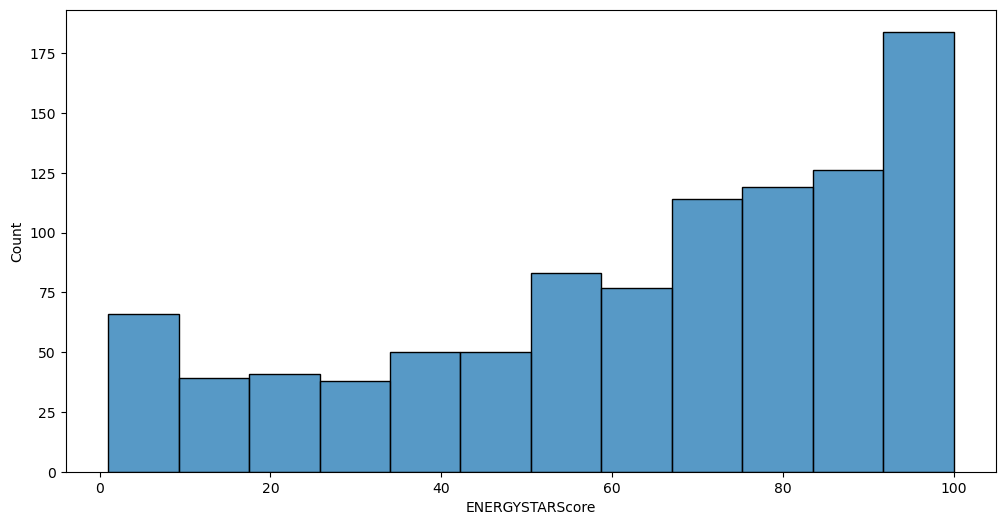

In [468]:
plt.figure(figsize=(12,6))
sns.histplot(data=ENERGYSTARS_core);

In [469]:
df["ENERGYSTARScore"] = ENERGYSTARS_core

In [470]:
fig = px.scatter(df, x='ENERGYSTARScore', y='SiteEnergyUse', trendline='ols')
pyo.iplot(fig, 'scatter-plot-energystar-ghg')

In [471]:
selected_columns = ['Neighborhood', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'DistanceToSeattle', 'ParkingScore', 'BuildingScore', 'SurfacePerBuilding',
                    'SurfacePerFloor', 'TotalUseTypeNumber','GasScore','ElectricityScore','SteamUse(kBtu)Score','PrimaryPropertyType','LargestPropertyUseType','ENERGYSTARScore']
X = df[selected_columns]
y_site = df["SiteEnergyUse"]

# Split the dataset into training and test sets for each target variable
X_train_site, X_test_site, y_train_site, y_test_site = train_test_split(X, y_site, test_size=0.2, random_state=42)
print(f"La taille de données d'entrainement : {X_train_site.shape[0]}")
print(f"La taille de données d'entrainement : {X_test_site.shape[0]}")

La taille de données d'entrainement : 789
La taille de données d'entrainement : 198


In [472]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'BuildingAge', 'DistanceToSeattle', 'ParkingScore',
                                      'BuildingScore', 'SurfacePerBuilding', 'SurfacePerFloor', 'TotalUseTypeNumber','GasScore','ElectricityScore','SteamUse(kBtu)Score','ENERGYSTARScore']),
        ('cat', categorical_transformer, ['Neighborhood','PrimaryPropertyType','LargestPropertyUseType'])
    ])

X_train_site_encoded = preprocessor.fit_transform(X_train_site)
X_test_site_encoded = preprocessor.transform(X_test_site)

In [473]:
y_train_site_log = np.log1p(y_train_site)

In [474]:
#Gradient Boosting Regressor
parameters_XG_ES = {
    "max_depth": [1, 3, 5, 7, 9, 11, 12],
    "max_features": ["auto", "log2", None],
}

grid_XG_ES = GridSearchCV(GradientBoostingRegressor(), parameters_XG_ES, cv=5)
grid_XG_ES.fit(X_train_site_encoded, y_train_site_log)
y_pred_XG_ES = grid_XG_ES.predict(X_test_site_encoded)




Feature: 0, Score: 0.00043
Feature: 1, Score: 0.00658
Feature: 2, Score: 0.69532
Feature: 3, Score: 0.00405
Feature: 4, Score: 0.00245
Feature: 5, Score: 0.00174
Feature: 6, Score: 0.00074
Feature: 7, Score: 0.01352
Feature: 8, Score: 0.00538
Feature: 9, Score: 0.00561
Feature: 10, Score: 0.00406
Feature: 11, Score: 0.02576
Feature: 12, Score: 0.00008
Feature: 13, Score: 0.08639
Feature: 14, Score: 0.00065
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00062
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00001
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00004
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00024
Feature: 25, Score: 0.00048
Feature: 26, Score: 0.00019
Feature: 27, Score: 0.00147
Feature: 28, Score: 0.00258
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00025
Feature: 31, Score: 0.00008
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00015
Feature: 34, Score: 0.00163
Feature: 35, Score: 0.00000
Fe

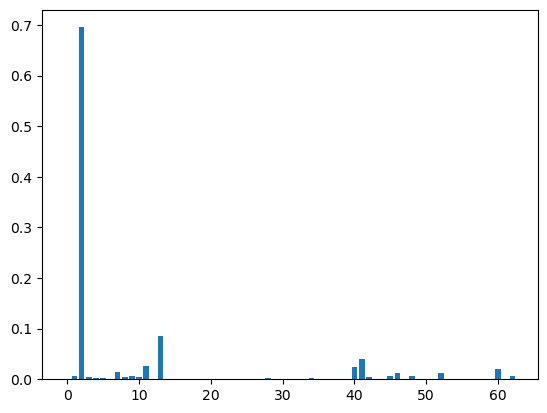

In [475]:
best_model_XG_ES = grid_XG_ES.best_estimator_

feature_importances_XG_ES = best_model_XG_ES.feature_importances_


for i, v in enumerate(feature_importances_XG_ES):
    print('Feature: %0d, Score: %.5f' % (i, v))

plt.bar([x for x in range(len(feature_importances_XG_ES))], feature_importances_XG_ES)
plt.show()

In [476]:
r2_XG_ES = round(r2_score(y_test_site, np.expm1(y_pred_XG_ES)), 3)
rmse_XG_ES = round(np.sqrt(metrics.mean_squared_error(y_test_site, np.expm1(y_pred_XG_ES))), 3)
mae_XG_ES = round(mean_absolute_error(y_test_site, np.expm1(y_pred_XG_ES)), 3)
time_XG_ES = round(grid_XG.cv_results_['mean_fit_time'].max(), 3)

print(grid_XG_ES.best_params_)
score('Gradient Boosting Regressor ENERGYSTARScore ', r2_XG_ES, rmse_XG_ES, mae_XG_ES, time_XG_ES)

{'max_depth': 3, 'max_features': 'auto'}


,modele,R2,RMSE,MAE,time
0,Gradient Boosting Regressor ENERGYSTARScore,0.657000,1.884755e+07,4.025102e+06,0.777
1,Gradient Boosting Regressor,0.624000,1.974095e+07,4.662064e+06,0.777
2,Decision Tree Regressor,0.555000,2.148535e+07,5.171799e+06,0.008
3,Extra Trees Regressor,0.552000,2.155473e+07,4.973834e+06,0.508
4,MLPRegressor,0.496095,2.285341e+07,5.684656e+06,0.015
5,RandomForestRegressor,0.430555,2.429421e+07,5.330557e+06,0.015
6,Bagging Regressor,0.424000,2.443508e+07,5.457322e+06,0.756
7,SVR1,0.396000,6.257545e+14,5.838264e+06,0.364
8,AdaBoost Regressor,0.335000,2.624749e+07,6.695223e+06,0.480
9,K Neighbors Regressor,0.323000,2.649612e+07,6.439078e+06,0.001


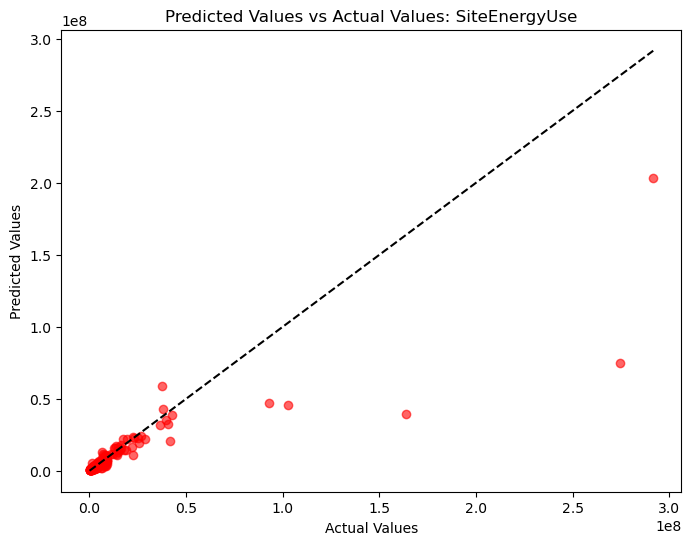

In [477]:
plot_pred(y_test_site, np.expm1(y_pred_XG_ES), color="red", title="Predicted Values vs Actual Values: SiteEnergyUse")


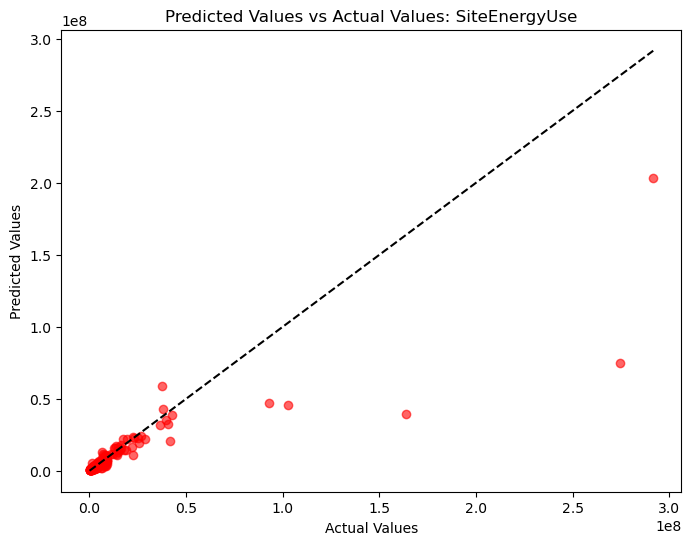

In [478]:
plot_pred(y_test_site, np.expm1(y_pred_XG_ES), color="red", title="Predicted Values vs Actual Values: SiteEnergyUse")


En utilisant la cote ENERGYSTAR, nous avons fait de bonnes prévisions pour  la réduction  de la consommation d'énergie dans les bâtiments non résidentiels de la ville de Seattle.

Gradient Boosting est l'algorithme qui nous donne les meilleurs résultats, et le temps calculé est beaucoup plus petit que les algorithmes Decision Tree Regressor , RandomForest, MLPRegressor et ExtraTrees.

La modèle que nous avons créé dans ce notebook peut être utile si la classification ENERGYSTAR est utilisée à l'avenir.